Hello Katharine!

I’m happy to review your project today.
I will mark your mistakes and give you some hints how it is possible to fix them. We are getting ready for real job, where your team leader/senior colleague will do exactly the same. Don't worry and study with pleasure! 

Below you will find my comments - **please do not move, modify or delete them**.

You can find my comments in green, yellow or red boxes like this:

<div class="alert alert-block alert-success">
<b>Reviewer's comment</b> <a class="tocSkip"></a>

Success. Everything is done succesfully.
</div>

<div class="alert alert-block alert-warning">
<b>Reviewer's comment</b> <a class="tocSkip"></a>

Remarks. Some recommendations.
</div>

<div class="alert alert-block alert-danger">

<b>Reviewer's comment</b> <a class="tocSkip"></a>

Needs fixing. The block requires some corrections. Work can't be accepted with the red comments.
</div>

You can answer me by using this:

<div class="alert alert-block alert-info">
<b>Student answer.</b> <a class="tocSkip"></a>

Text

</div>

# Introduction

This project is intended to provide valueable churn insight to Interconnect telecom operator using data from users of their services. Specifically, the data will be analyzed in terms of what factors contribute to Interconnect users discontinuing use of services. By the data, a binary classification machine learning model will be trained so that Interconnect can use it to predict which of their current users are likely to leave at any given time. This will allow Intercom to offer promotional codes and/or special plan options to insentivize said users to stay. The goal of this project is to maximize the model's AUC-ROC score, a metric ranging from 0 to 1 that measures how well a classification model distinguishes between classes.

# Initialization

In [1]:
import pandas as pd
import numpy as np

from IPython.display import Markdown
import re
from functools import reduce

from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import classification_report, roc_auc_score

# Load Data

In [2]:
contract_url = 'https://raw.githubusercontent.com/pvnkd0v3/churn_prediction_final_project/refs/heads/main/contract.csv'
personal_url = 'https://raw.githubusercontent.com/pvnkd0v3/churn_prediction_final_project/refs/heads/main/personal.csv'
internet_url = 'https://raw.githubusercontent.com/pvnkd0v3/churn_prediction_final_project/refs/heads/main/internet.csv'
phone_url = 'https://raw.githubusercontent.com/pvnkd0v3/churn_prediction_final_project/refs/heads/main/phone.csv'

contract = pd.read_csv(contract_url)
personal = pd.read_csv(personal_url)
internet = pd.read_csv(internet_url)
phone = pd.read_csv(phone_url)

# Data Preprocessing

In [3]:
df_list = [contract, personal, internet, phone]
df_names= ['Contract', 'Personal', 'Internet', 'Phone']

def view_data(rng):
    for i in rng:
        display(Markdown(f"### **{df_names[i]}**"))
        display(df_list[i].head(), display(df_list[i].info()))
        
view_data(range(0, 4))

### **Contract**

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


None

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


None

### **Personal**

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


None

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


None

### **Internet**

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


None

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


None

### **Phone**

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


None

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


None

## Streamline columns

In [4]:
def convert_to_snakecase(df):
    df.columns = [
        re.sub(r'([a-z])([A-Z])', r'\1_\2', col).lower().replace(" ", "_")
        for col in df.columns
    ]
    return df

for df in df_list:
    convert_to_snakecase(df)

In [5]:
contract['begin_date'] = pd.to_datetime(contract['begin_date'], format='%Y-%m-%d')

non_numeric = contract[~contract['total_charges'].apply(pd.to_numeric, errors='coerce').notna()]
#display(non_numeric)
contract['total_charges'] = pd.to_numeric(contract['total_charges'], errors='coerce')

In [6]:
view_data(range(0,4))

### **Contract**

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   end_date           7043 non-null   object        
 3   type               7043 non-null   object        
 4   paperless_billing  7043 non-null   object        
 5   payment_method     7043 non-null   object        
 6   monthly_charges    7043 non-null   float64       
 7   total_charges      7032 non-null   float64       
dtypes: datetime64[ns](1), float64(2), object(5)
memory usage: 440.3+ KB


None

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.50
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


None

### **Personal**

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   customer_id     7043 non-null   object
 1   gender          7043 non-null   object
 2   senior_citizen  7043 non-null   int64 
 3   partner         7043 non-null   object
 4   dependents      7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


None

,customer_id,gender,senior_citizen,partner,dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


None

### **Internet**

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   customer_id        5517 non-null   object
 1   internet_service   5517 non-null   object
 2   online_security    5517 non-null   object
 3   online_backup      5517 non-null   object
 4   device_protection  5517 non-null   object
 5   tech_support       5517 non-null   object
 6   streaming_tv       5517 non-null   object
 7   streaming_movies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


None

,customer_id,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


None

### **Phone**

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   customer_id     6361 non-null   object
 1   multiple_lines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


None

,customer_id,multiple_lines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


None

## Check for errors and null values

In [7]:
def print_unique_object_values(df):
    for col in df.select_dtypes(include='object').columns:
        unique_values = df[col].unique()
        print(f"{col}")
        print(f"{unique_values}\n")
        
for df in df_list:
    print_unique_object_values(df)

customer_id
['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' ... '4801-JZAZL' '8361-LTMKD'
 '3186-AJIEK']

end_date
['No' '2019-12-01 00:00:00' '2019-11-01 00:00:00' '2019-10-01 00:00:00'
 '2020-01-01 00:00:00']

type
['Month-to-month' 'One year' 'Two year']

paperless_billing
['Yes' 'No']

payment_method
['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']

customer_id
['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' ... '4801-JZAZL' '8361-LTMKD'
 '3186-AJIEK']

gender
['Female' 'Male']

partner
['Yes' 'No']

dependents
['No' 'Yes']

customer_id
['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' ... '4801-JZAZL' '8361-LTMKD'
 '3186-AJIEK']

internet_service
['DSL' 'Fiber optic']

online_security
['No' 'Yes']

online_backup
['Yes' 'No']

device_protection
['No' 'Yes']

tech_support
['No' 'Yes']

streaming_tv
['No' 'Yes']

streaming_movies
['No' 'Yes']

customer_id
['5575-GNVDE' '3668-QPYBK' '9237-HQITU' ... '2234-XADUH' '8361-LTMKD'
 '3186-AJIEK']

multiple_lines
['No' 'Yes']


In [8]:
for df in df_list:
    df = df.replace(r'^\s*$', np.nan, regex=True)
    print(df.isnull().sum())

customer_id           0
begin_date            0
end_date              0
type                  0
paperless_billing     0
payment_method        0
monthly_charges       0
total_charges        11
dtype: int64
customer_id       0
gender            0
senior_citizen    0
partner           0
dependents        0
dtype: int64
customer_id          0
internet_service     0
online_security      0
online_backup        0
device_protection    0
tech_support         0
streaming_tv         0
streaming_movies     0
dtype: int64
customer_id       0
multiple_lines    0
dtype: int64


In [9]:
contract = contract.dropna()

## Merge data

In [10]:
customer_df = reduce(lambda left, right: pd.merge(left, right, on='customer_id', how='outer'), df_list)

display(customer_df)
print(customer_df.info())

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,NaN
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.50,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,2018-02-01,No,One year,Yes,Mailed check,84.80,1990.50,Male,0,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,Yes,Yes
7039,2234-XADUH,2014-02-01,No,One year,Yes,Credit card (automatic),103.20,7362.90,Female,0,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,Yes
7040,4801-JZAZL,2019-03-01,No,Month-to-month,Yes,Electronic check,29.60,346.45,Female,0,Yes,Yes,DSL,Yes,No,No,No,No,No,NaN
7041,8361-LTMKD,2019-07-01,2019-11-01 00:00:00,Month-to-month,Yes,Mailed check,74.40,306.60,Male,1,Yes,No,Fiber optic,No,No,No,No,No,No,Yes


<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   end_date           7043 non-null   object        
 3   type               7043 non-null   object        
 4   paperless_billing  7043 non-null   object        
 5   payment_method     7043 non-null   object        
 6   monthly_charges    7043 non-null   float64       
 7   total_charges      7032 non-null   float64       
 8   gender             7043 non-null   object        
 9   senior_citizen     7043 non-null   int64         
 10  partner            7043 non-null   object        
 11  dependents         7043 non-null   object        
 12  internet_service   5517 non-null   object        
 13  online_security    5517 non-null   object        
 14  online_b

In [11]:
customer_df = customer_df.dropna(subset=['total_charges'])
customer_df['multiple_lines'] = customer_df['multiple_lines'].fillna('No Lines')
customer_df = customer_df.fillna('No')

In [12]:
customer_df['has_internet'] = np.where(customer_df['internet_service'] == 'No', 0, 1)
customer_df['has_phone'] = np.where(customer_df['multiple_lines'] == 'No Lines', 0, 1)

In [13]:
customer_df = customer_df.set_index('customer_id')

In [14]:
display(customer_df)
customer_df.info()

,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,...,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,has_internet,has_phone
customer_id,,,,,,,,,,,,,,,,,,,,,
7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,Female,0,Yes,...,DSL,No,Yes,No,No,No,No,No Lines,1,0
5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.50,Male,0,No,...,DSL,Yes,No,Yes,No,No,No,No,1,1
3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,Male,0,No,...,DSL,Yes,Yes,No,No,No,No,No,1,1
7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,Male,0,No,...,DSL,Yes,No,Yes,Yes,No,No,No Lines,1,0
9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,Female,0,No,...,Fiber optic,No,No,No,No,No,No,No,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6840-RESVB,2018-02-01,No,One year,Yes,Mailed check,84.80,1990.50,Male,0,Yes,...,DSL,Yes,No,Yes,Yes,Yes,Yes,Yes,1,1
2234-XADUH,2014-02-01,No,One year,Yes,Credit card (automatic),103.20,7362.90,Female,0,Yes,...,Fiber optic,No,Yes,Yes,No,Yes,Yes,Yes,1,1
4801-JZAZL,2019-03-01,No,Month-to-month,Yes,Electronic check,29.60,346.45,Female,0,Yes,...,DSL,Yes,No,No,No,No,No,No Lines,1,0


<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   begin_date         7032 non-null   datetime64[ns]
 1   end_date           7032 non-null   object        
 2   type               7032 non-null   object        
 3   paperless_billing  7032 non-null   object        
 4   payment_method     7032 non-null   object        
 5   monthly_charges    7032 non-null   float64       
 6   total_charges      7032 non-null   float64       
 7   gender             7032 non-null   object        
 8   senior_citizen     7032 non-null   int64         
 9   partner            7032 non-null   object        
 10  dependents         7032 non-null   object        
 11  internet_service   7032 non-null   object        
 12  online_security    7032 non-null   object        
 13  online_backup      7032 non-null   object        
 14

## Summary

All columns were converted to snakecase and assigned appropriate datatypes. The contract, personal, internet, and phone dataframes were merged. Null values that were due to a customer not using a particular service were imputed with 'No' (or 'No Service' in the case of multiple_lines column). All other null values were dropped (11 columns with null total_charges values). Columns indicating if customers used any phone or internet services were added and the index of the dataframe was set to the customer_id column.

# Exploratory Data Analysis

In [15]:
churn = customer_df[customer_df['end_date'] != 'No']
non_churn = customer_df[customer_df['end_date'] == 'No']

print(f'{round((len(churn) / len(customer_df)) * 100, 1)}% of customers have discontinued services.')

26.6% of customers have discontinued services.


## Churn Seasonality

/tmp/ipykernel_400/3109056535.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  churn['end_date'] = pd.to_datetime(churn['end_date'], format='%Y-%m-%d')


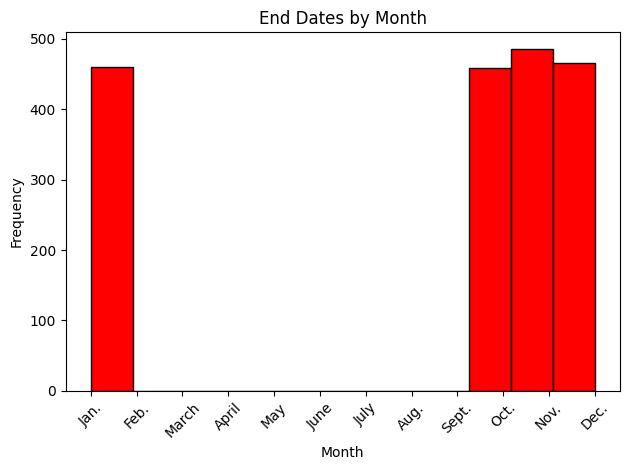

In [16]:
churn['end_date'] = pd.to_datetime(churn['end_date'], format='%Y-%m-%d')


fig, ax = plt.subplots()
ax.hist(churn['end_date'].dt.month, bins=12, edgecolor='black', color='red')

xtick_labels = ['Jan.', 'Feb.', 'March', 'April', 'May', 'June', 
                'July', 'Aug.', 'Sept.', 'Oct.', 'Nov.', 'Dec.']
ax.set_xticks(range(1, 13))  
ax.set_xticklabels(xtick_labels, rotation=45)
ax.set_xlabel('Month')
ax.set_ylabel('Frequency')
ax.set_title('End Dates by Month')
plt.tight_layout()
plt.show()
plt.close()

All customers who have discontinued service have done so within a 4 month time period from Spetember through January with the most customers leaving in October. It could be suggested that Interconnect could offer promotions/discounts towards the end of each year to prevent customers from terminating service.

## Internet vs TV Users

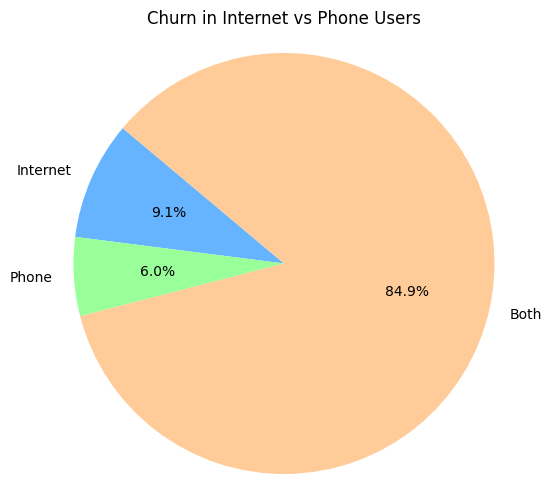

In [17]:
churn_internet = churn[(churn['has_internet'] == 1) & (churn['has_phone'] == 0)]
churn_phone = churn[(churn['has_internet'] == 0) & (churn['has_phone'] == 1)]
churn_both = churn[(churn['has_internet'] == 1) & (churn['has_phone'] == 1)]

counts = [len(churn_internet), len(churn_phone), len(churn_both)]
count_labels = ['Internet', 'Phone', 'Both']
count_colors = ['#66b3ff','#99ff99','#ffcc99']

plt.figure(figsize=(6,6))
plt.pie(counts, labels=count_labels, autopct='%1.1f%%', startangle=140, colors=count_colors)
plt.title('Churn in Internet vs Phone Users')
plt.axis('equal')  
plt.show()
plt.close()

The vast majority of customers who have left were users of both Interconnect's phone and internet services. It could be suggested that Interconnect offer discounted phone and internet bundles to customers who use both services.

## Churn Demographics

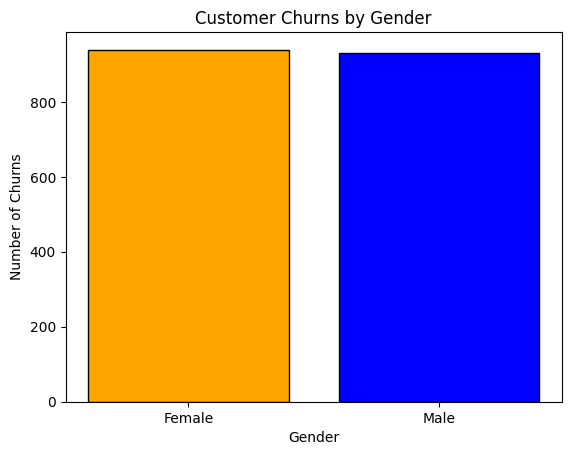

Female    939
Male      930
Name: gender, dtype: int64


In [18]:
gender_counts = churn['gender'].value_counts()

colors = ['blue' if gender == 'Male' else 'orange' for gender in gender_counts.index]
fig, ax = plt.subplots()

ax.bar(gender_counts.index, gender_counts.values, color=colors, edgecolor='black')
ax.set_xlabel("Gender")
ax.set_ylabel("Number of Churns")
ax.set_title("Customer Churns by Gender")
plt.show()
plt.close()

print(gender_counts)

There appears to me no significant difference between number of churns by gender.

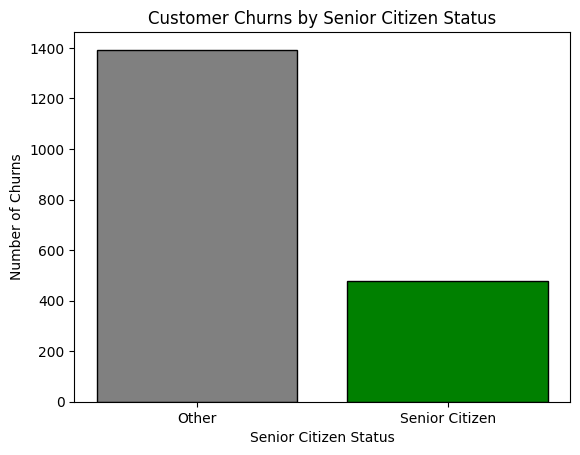

0    1393
1     476
Name: senior_citizen, dtype: int64


In [19]:
senior_counts = churn['senior_citizen'].value_counts()


colors = ['green' if senior == 1 else 'grey' for senior in senior_counts.index]


fig, ax = plt.subplots()
ax.bar(senior_counts.index, senior_counts.values, color=colors, edgecolor='black')

ax.set_xticks([0, 1])
ax.set_xticklabels(['Other', 'Senior Citizen'])
ax.set_xlabel("Senior Citizen Status")
ax.set_ylabel("Number of Churns")
ax.set_title("Customer Churns by Senior Citizen Status")

plt.show()

print(senior_counts)

Most customers who churn are not senior citizens.

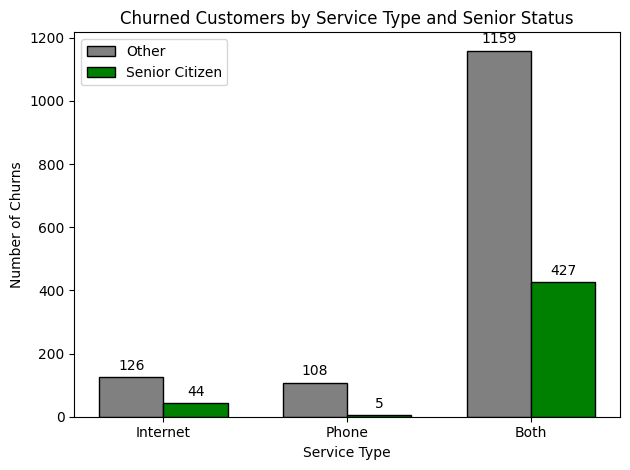

In [20]:
churn_seniors = churn[churn['senior_citizen'] == 1]
churn_non_seniors = churn[churn['senior_citizen'] == 0]

def service_combo_counts(df):
    internet = int(len(df[(df['has_internet'] == 1) & (df['has_phone'] == 0)]))
    phone = int(len(df[(df['has_internet'] == 0) & (df['has_phone'] == 1)]))
    both = int(len(df[(df['has_internet'] == 1) & (df['has_phone'] == 1)]))
    return [internet, phone, both]

senior_counts = service_combo_counts(churn_seniors)
non_senior_counts = service_combo_counts(churn_non_seniors)


labels = ['Internet', 'Phone', 'Both']
x = np.arange(len(labels))  
width = 0.35  

# Plot
fig, ax = plt.subplots()
bars1 = ax.bar(x - width/2, non_senior_counts, width, label='Other', color='grey', edgecolor='black')
bars2 = ax.bar(x + width/2, senior_counts, width, label='Senior Citizen', color='green', edgecolor='black')


ax.set_xlabel('Service Type')
ax.set_ylabel('Number of Churns')
ax.set_title('Churned Customers by Service Type and Senior Status')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

plt.tight_layout()
plt.show()
plt.close()

The majority of churned customers being non-senior citizens who have both internet and phone lends more creedence to the idea that phone and internet services can be bundled at a discount to incentivize people likely to churn to keep their services. 

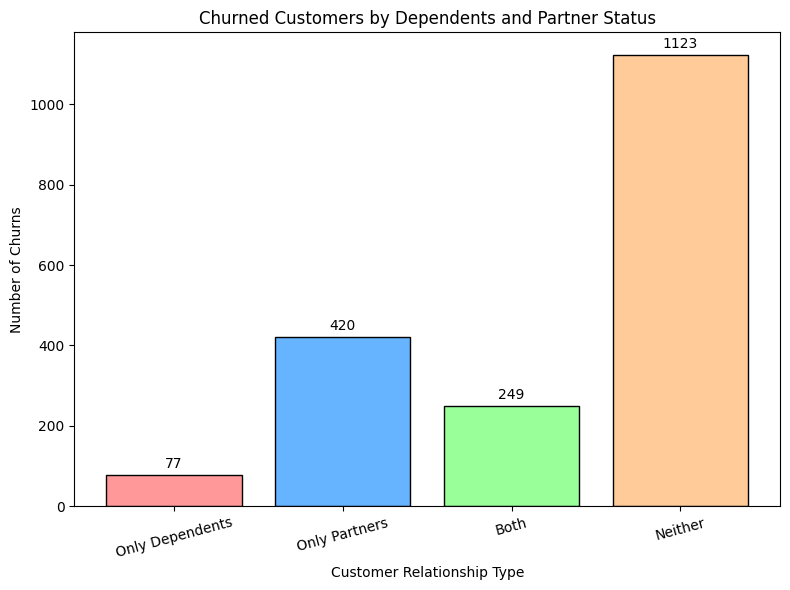

In [21]:
just_dependents = churn[(churn['dependents'] == 'Yes') & (churn['partner'] == 'No')]
just_partners = churn[(churn['dependents'] == 'No') & (churn['partner'] == 'Yes')]
both_partner_dependent = churn[(churn['dependents'] == 'Yes') & (churn['partner'] == 'Yes')]
neither = churn[(churn['dependents'] == 'No') & (churn['partner'] == 'No')]

counts = [
    len(just_dependents),
    len(just_partners),
    len(both_partner_dependent),
    len(neither)
]

labels = ['Only Dependents', 'Only Partners', 'Both', 'Neither']
colors = ['#ff9999', '#66b3ff', '#99ff99', '#ffcc99']  # pastel colors for fun

fig, ax = plt.subplots(figsize=(8, 6))
bars = ax.bar(labels, counts, color=colors, edgecolor='black')


for bar in bars:
    height = bar.get_height()
    ax.annotate(f'{height}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),
                textcoords='offset points',
                ha='center', va='bottom')


ax.set_ylabel("Number of Churns")
ax.set_xlabel("Customer Relationship Type")
ax.set_title("Churned Customers by Dependents and Partner Status")
plt.xticks(rotation=15)
plt.tight_layout()

plt.show()
plt.close()

The majority of churned customers are single people without dependents. Perhaps this demographic could be incentivized with personalized plans which could lead to more flexibility or discounts depending on what services they choose. It could also be offered to them to 'add a friend' to their plan which would not only lead to a small discount but a new customer.

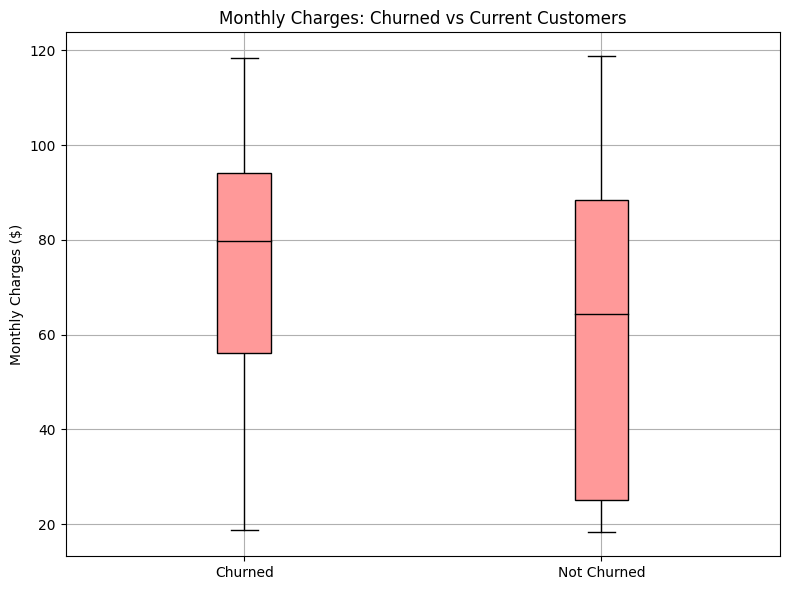

In [22]:
data = [churn['monthly_charges'], non_churn['monthly_charges']]
labels = ['Churned', 'Not Churned']

fig, ax = plt.subplots(figsize=(8, 6))
ax.boxplot(data, labels=labels, patch_artist=True,
           boxprops=dict(facecolor='#ff9999'),
           medianprops=dict(color='black'))

ax.set_title("Monthly Charges: Churned vs Current Customers")
ax.set_ylabel("Monthly Charges ($)")
plt.grid(True)
plt.tight_layout()
plt.show()
plt.close()

In [23]:
t_stat, p_val = ttest_ind(churn['monthly_charges'], non_churn['monthly_charges'], equal_var=False)

print(f"T-statistic: {t_stat:.2f}")
print(f"P-value: {p_val:.4f}")

T-statistic: 18.34
P-value: 0.0000


There is a highly significant difference in the monthly charges of churned vs current customers. The probability of this difference being by chance is essentially zero. Churned customers tend to have higher monthly bills lending creedence to the reccomendations of discounts in the form of bundles, personalized plans, and/or the ability to add people to plans. 

## Summary of Possible Churn Solutions 

- Offer pre-existing or new promotions/discounts at the end of the year
- Offer bundled plans to customers who use both internet and phone services at a discount
- Offer personalized plans to provide more flexibility and possible discounts to single customers
- Offer the abilioty ' 'add a friend' to plans of single customers at a small discount

# Feature Engineeering

In [24]:
df = customer_df.copy()

df['begin_month'] = df['begin_date'].dt.month
df.drop('begin_date', axis=1, inplace=True)

df['churn'] = df['end_date'].apply(lambda x: 0 if x == 'No' else 1)
df.drop('end_date', axis=1, inplace=True)

print(df.info())
display(df.head())

<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   type               7032 non-null   object 
 1   paperless_billing  7032 non-null   object 
 2   payment_method     7032 non-null   object 
 3   monthly_charges    7032 non-null   float64
 4   total_charges      7032 non-null   float64
 5   gender             7032 non-null   object 
 6   senior_citizen     7032 non-null   int64  
 7   partner            7032 non-null   object 
 8   dependents         7032 non-null   object 
 9   internet_service   7032 non-null   object 
 10  online_security    7032 non-null   object 
 11  online_backup      7032 non-null   object 
 12  device_protection  7032 non-null   object 
 13  tech_support       7032 non-null   object 
 14  streaming_tv       7032 non-null   object 
 15  streaming_movies   7032 non-null   object 
 16  multiple_lines

,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,...,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,has_internet,has_phone,begin_month,churn
customer_id,,,,,,,,,,,,,,,,,,,,,
7590-VHVEG,Month-to-month,Yes,Electronic check,29.85,29.85,Female,0,Yes,No,DSL,...,Yes,No,No,No,No,No Lines,1,0,1,0
5575-GNVDE,One year,No,Mailed check,56.95,1889.50,Male,0,No,No,DSL,...,No,Yes,No,No,No,No,1,1,4,0
3668-QPYBK,Month-to-month,Yes,Mailed check,53.85,108.15,Male,0,No,No,DSL,...,Yes,No,No,No,No,No,1,1,10,1
7795-CFOCW,One year,No,Bank transfer (automatic),42.30,1840.75,Male,0,No,No,DSL,...,No,Yes,Yes,No,No,No Lines,1,0,5,0
9237-HQITU,Month-to-month,Yes,Electronic check,70.70,151.65,Female,0,No,No,Fiber optic,...,No,No,No,No,No,No,1,1,9,1


In [25]:
categorical_cols = ['type', 'paperless_billing', 'payment_method',
                    'gender', 'senior_citizen', 'partner',
                   'dependents', 'internet_service', 'online_security',
                   'online_backup', 'device_protection', 'tech_support',
                   'streaming_tv', 'streaming_movies', 'multiple_lines',
                   'has_internet', 'has_phone', 'begin_month']  
numeric_cols = ['monthly_charges', 'total_charges']  


preprocessor_lr = ColumnTransformer([
    ('num', Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler())
    ]), numeric_cols),
    ('cat', Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('encoder', OneHotEncoder(handle_unknown='ignore'))
    ]), categorical_cols)
])


preprocessor_tree = ColumnTransformer([
    ('num', SimpleImputer(strategy='mean'), numeric_cols),
    ('cat', Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
    ]), categorical_cols)
])

In [26]:
pipeline_lr = Pipeline([
    ('preprocessor', preprocessor_lr),
    ('classifier', LogisticRegression(max_iter=1000, class_weight='balanced'))
])


pipeline_rf = Pipeline([
    ('preprocessor', preprocessor_tree),
    ('classifier', RandomForestClassifier(class_weight='balanced'))
])


pipeline_xgb = Pipeline([
    ('preprocessor', preprocessor_tree),
    ('classifier', XGBClassifier(use_label_encoder=False, eval_metric='auc', scale_pos_weight=2.76))  # Tune scale_pos_weight
])


pipeline_lgbm = Pipeline([
    ('preprocessor', preprocessor_tree),
    ('classifier', LGBMClassifier(class_weight='balanced'))
])

In [27]:
X = df.drop(columns='churn')
y = df['churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=11)

pipeline_lr.fit(X_train, y_train)
pipeline_rf.fit(X_train, y_train)
pipeline_xgb.fit(X_train, y_train)
pipeline_lgbm.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', SimpleImputer(),
                                                  ['monthly_charges',
                                                   'total_charges']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                  unknown_value=-1))]),
                                                  ['type', 'paperless_billing',
                                                   'payment_method', 'gender',
                                                  

# Train and Evaluate

In [28]:
param_grid_rf = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [5, 10, None],
    'classifier__min_samples_split': [2, 5],
    'classifier__min_samples_leaf': [1, 2],
}


param_grid_lr = {
    'classifier__C': [0.01, 0.1, 1, 10],
    'classifier__penalty': ['l2'],
    'classifier__solver': ['lbfgs', 'liblinear']
}


param_grid_xgb = {
    'classifier__max_depth': [3, 6],
    'classifier__learning_rate': [0.01, 0.1],
    'classifier__n_estimators': [100, 200]
}


param_grid_lgbm = {
    'classifier__num_leaves': [31, 50],
    'classifier__max_depth': [-1, 5, 10],
    'classifier__learning_rate': [0.05, 0.1],
    'classifier__n_estimators': [100, 200]
}


grid_rf = GridSearchCV(pipeline_rf, param_grid_rf, cv=5, n_jobs=-1, scoring='accuracy', verbose=1)
grid_lr = GridSearchCV(pipeline_lr, param_grid_lr, cv=5, n_jobs=-1, scoring='accuracy', verbose=1)
grid_xgb = GridSearchCV(pipeline_xgb, param_grid_xgb, cv=5, n_jobs=-1, scoring='accuracy', verbose=1)
grid_lgbm = GridSearchCV(pipeline_lgbm, param_grid_lgbm, cv=5, n_jobs=-1, scoring='accuracy', verbose=1)

grid_rf.fit(X_train, y_train)
grid_lr.fit(X_train, y_train)
grid_xgb.fit(X_train, y_train)
grid_lgbm.fit(X_train, y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Fitting 5 folds for each of 24 candidates, totalling 120 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         SimpleImputer(),
                                                                         ['monthly_charges',
                                                                          'total_charges']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('encoder',
                                                                                          OrdinalEncoder(handle_unknown='use_encoded_value',
              

In [29]:
cv_scores_rf = cross_val_score(grid_rf.best_estimator_, X_train, y_train, cv=5, scoring='accuracy')
cv_scores_lr = cross_val_score(grid_lr.best_estimator_, X_train, y_train, cv=5, scoring='accuracy')
cv_scores_xgb = cross_val_score(grid_xgb.best_estimator_, X_train, y_train, cv=5, scoring='accuracy')
cv_scores_lgbm = cross_val_score(grid_lgbm.best_estimator_, X_train, y_train, cv=5, scoring='accuracy')

print(f"Random Forest CV Accuracy: {cv_scores_rf.mean():.4f}")
print(f"Logistic Regression CV Accuracy: {cv_scores_lr.mean():.4f}")
print(f"XGBoost CV Accuracy: {cv_scores_xgb.mean():.4f}")
print(f"LightGBM CV Accuracy: {cv_scores_lgbm.mean():.4f}")
print()

y_pred_prob_rf = grid_rf.best_estimator_.predict_proba(X_test)[:, 1]
y_pred_prob_lr = grid_lr.best_estimator_.predict_proba(X_test)[:, 1]
y_pred_prob_xgb = grid_xgb.best_estimator_.predict_proba(X_test)[:, 1]
y_pred_prob_lgbm = grid_lgbm.best_estimator_.predict_proba(X_test)[:, 1]

print(f"Random Forest AUC: {roc_auc_score(y_test, y_pred_prob_rf):.4f}")
print(f"Logistic Regression AUC: {roc_auc_score(y_test, y_pred_prob_lr):.4f}")
print(f"XGBoost AUC: {roc_auc_score(y_test, y_pred_prob_xgb):.4f}")
print(f"LightGBM AUC: {roc_auc_score(y_test, y_pred_prob_lgbm):.4f}")

Random Forest CV Accuracy: 0.8347
Logistic Regression CV Accuracy: 0.7525
XGBoost CV Accuracy: 0.8324
LightGBM CV Accuracy: 0.8494

Random Forest AUC: 0.8661
Logistic Regression AUC: 0.8464
XGBoost AUC: 0.8940
LightGBM AUC: 0.8902


In [30]:
print("Best parameters for LightGBM:")
print(grid_lgbm.best_params_)

Best parameters for LightGBM:
{'classifier__learning_rate': 0.1, 'classifier__max_depth': -1, 'classifier__n_estimators': 200, 'classifier__num_leaves': 50}


# Results

LinearRegression, RandomForest, XGBoost, and LightGBM models were trained and evaluated on customer data based on accuracy and AUC-ROC score. The optimal model for predicting whether or not an Interconnect customer will churn is the LightGBM model with the above parameters (see Cell 31 output). It returned an AUC-ROC score of 0.89 along with an accuracy score of 0.84, the highest scores of all models trained and evaluated. 

<div class="alert alert-block alert-success">
<b>Reviewer's comment V1</b> <a class="tocSkip"></a>

You did a great job! Everything is correct. Well done! Based on your roc-auc score you achieved 6.0/6.0 sp. Not many students manage to achieve such high quality.

Good luck with your new job search!

</div>